# 1. Imports

In [580]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set(style="whitegrid")
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import re
from mlxtend.classifier import StackingCVClassifier

# 2. Load and Check Data

In [548]:
train_df = pd.read_csv('/home/david/Titanic/train.csv', index_col='PassengerId')
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB
None


In [549]:
train_df[train_df.Embarked.isnull()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


We can see that these two passengers shared Cabin and belonged to Pclass 1, so it seems a sensible approach to fill the two missing values with the most common value of Embarked among people belonging to Pclass 1.

In [550]:
train_df.loc[(train_df.Pclass == 1) & (train_df.Sex == 'female'), 'Embarked'].mode()

0    S
dtype: object

In [551]:
train_df['Embarked'] = train_df['Embarked'].fillna('S')
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    891 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB
None


In [552]:
test_df = pd.read_csv('/home/david/Titanic/test.csv', index_col='PassengerId')
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
Pclass      418 non-null int64
Name        418 non-null object
Sex         418 non-null object
Age         332 non-null float64
SibSp       418 non-null int64
Parch       418 non-null int64
Ticket      418 non-null object
Fare        417 non-null float64
Cabin       91 non-null object
Embarked    418 non-null object
dtypes: float64(2), int64(3), object(5)
memory usage: 35.9+ KB
None


In the test set there are several missing values in Age and only one in Fare. The latter will be filled with the median value, while the former values will be filled using KNN mean imputation. Cabin will not be used in the analysis

# 3. EDA

## 3.1. Pclass Analysis

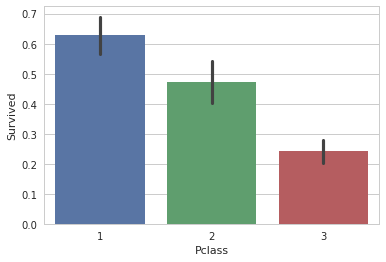

In [553]:
sns.barplot(x='Pclass', y='Survived', data=train_df)
plt.show()

In [554]:
train_df[['Pclass', 'Survived']].groupby('Pclass').mean()

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


## 3.2. Sex Analysis

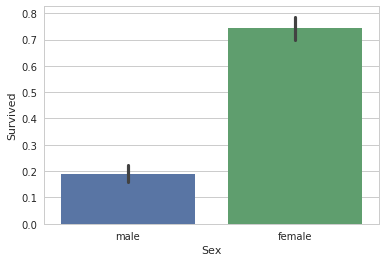

In [555]:
sns.barplot(x='Sex', y='Survived', data=train_df)
plt.show()

In [556]:
train_df[['Sex', 'Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.742038
male,0.188908


## 3.3. Embarked Analysis

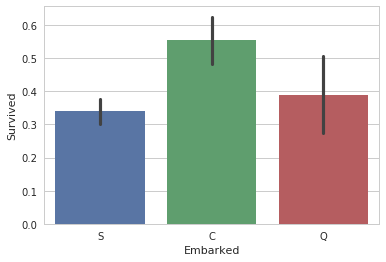

In [557]:
sns.barplot(x='Embarked', y='Survived', data=train_df)
plt.show()

In [558]:
train_df[['Embarked', 'Survived']].groupby('Embarked').mean()

,Survived
Embarked,
C,0.553571
Q,0.389610
S,0.339009


## 3.4. Pclass-Sex Analysis

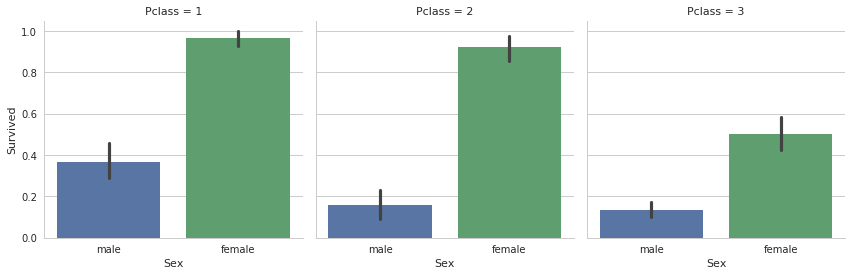

In [559]:
sns.factorplot(x='Sex', y='Survived', data=train_df, col='Pclass', kind='bar')
plt.show()

## 3.5. Pclass-Embarked Analysis

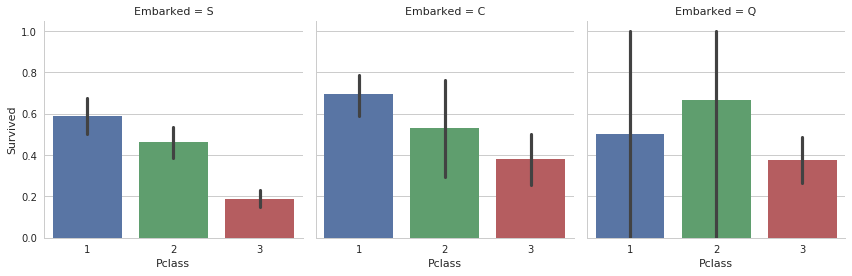

In [560]:
sns.factorplot(x='Pclass', y='Survived', data=train_df, col='Embarked', kind='bar')
plt.show()

## 3.6. Embarked-Sex Analysis

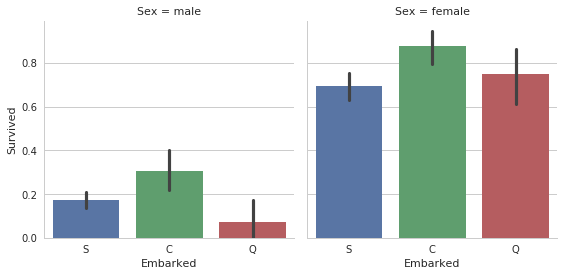

In [561]:
sns.factorplot(x='Embarked', y='Survived', data=train_df, col='Sex', kind='bar')
plt.show()

## 3.7. Sex-Pclass-Embarked Analysis

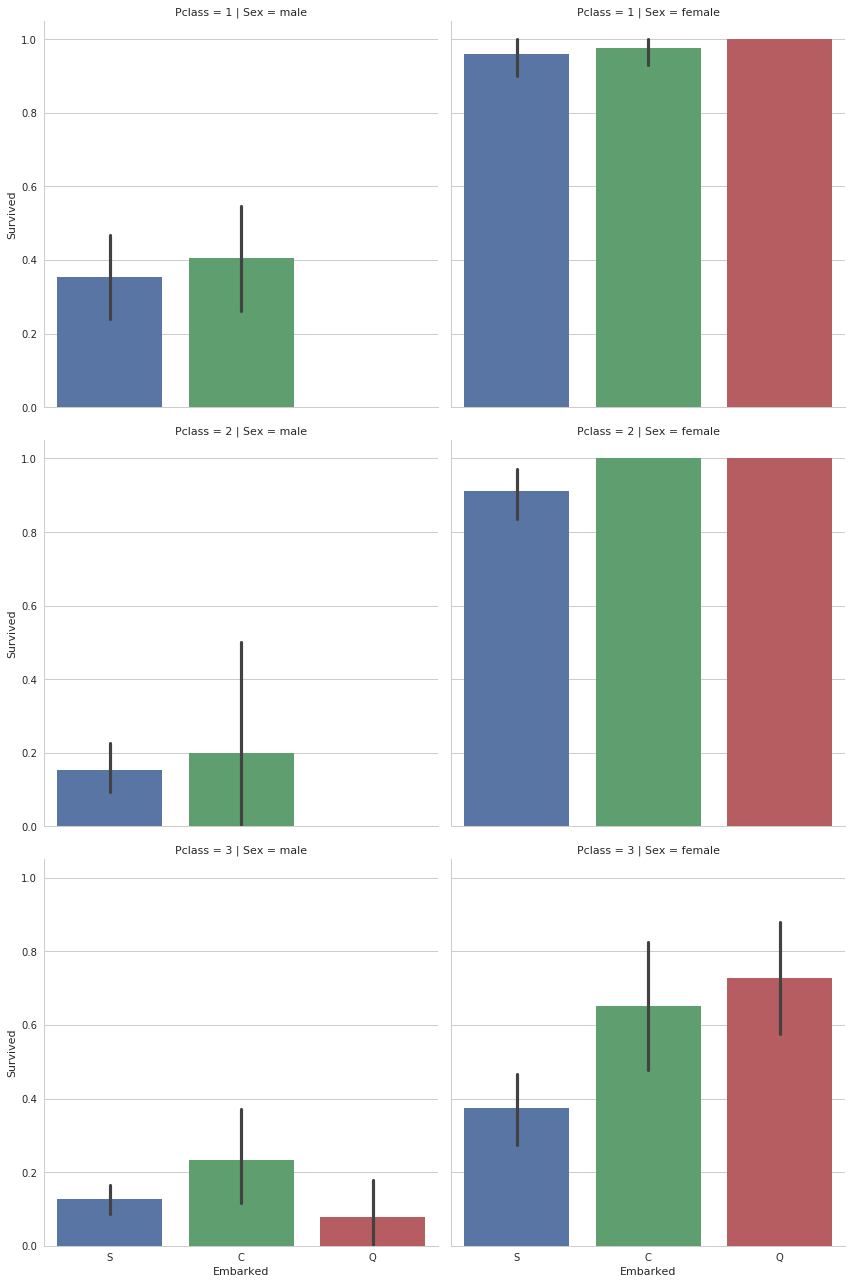

In [562]:
sns.factorplot(x='Embarked', y='Survived', data=train_df, col='Sex', row='Pclass', kind='bar', size=6)
plt.show()

## 3.8. SibSp Analysis

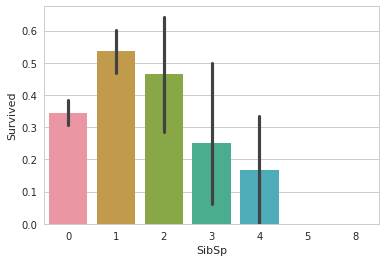

In [563]:
sns.barplot(x='SibSp', y='Survived', data=train_df)
plt.show()

In [564]:
train_df['SibSp'].value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

## 3.9. Parch Analysis

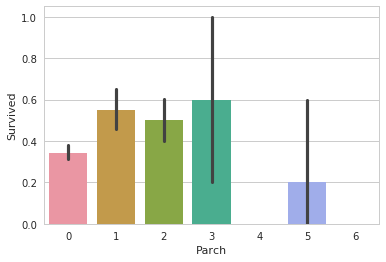

In [565]:
sns.barplot(x='Parch', y='Survived', data=train_df)
plt.show()

In [566]:
train_df['Parch'].value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

## 3.10. Age Analysis

In [567]:
train_df['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

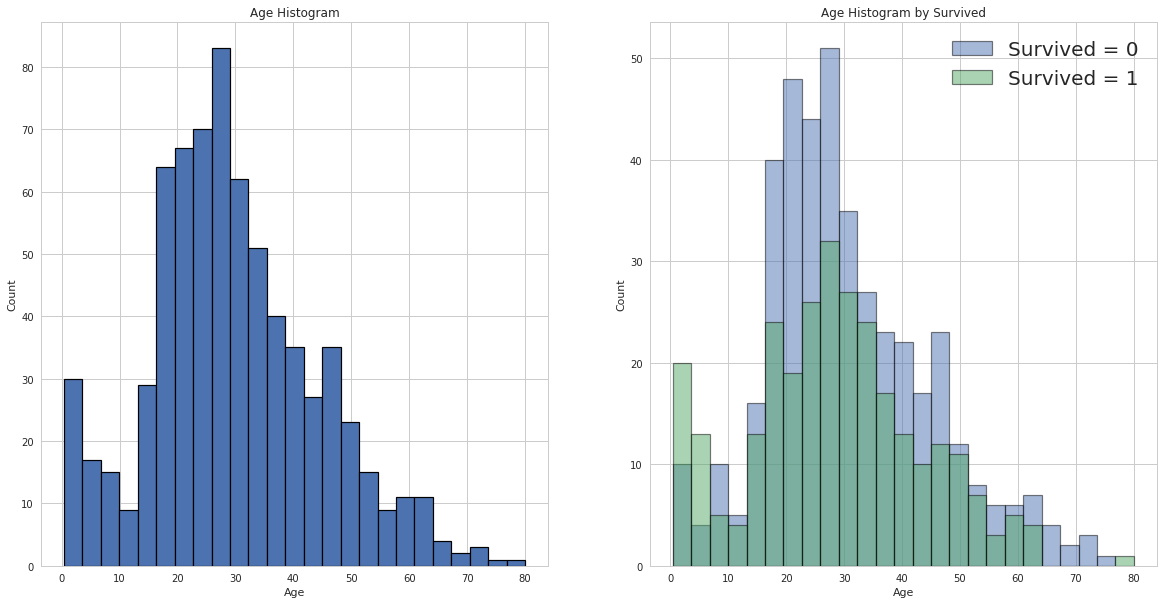

In [568]:
_, (ax1, ax2) = plt.subplots(1, 2,figsize=(20, 10))
_, bins = np.histogram(train_df['Age'].dropna(), bins=25)
ax1.hist(train_df['Age'].dropna(), bins=bins, edgecolor='black', linewidth=1.2)
ax1.set_xlabel('Age')
ax1.set_ylabel('Count')
ax1.set_title('Age Histogram')
ax2.hist(train_df.loc[train_df.Survived == 0, 'Age'].dropna(), bins=bins, edgecolor='black', linewidth=1.2, alpha=0.5, label='Survived = 0')
ax2.hist(train_df.loc[train_df.Survived == 1, 'Age'].dropna(), bins=bins, edgecolor='black', linewidth=1.2, alpha=0.5, label='Survived = 1')
ax2.set_xlabel('Age')
ax2.set_ylabel('Count')
ax2.set_title('Age Histogram by Survived')
plt.legend(loc='best', prop={'size': 20})
plt.show()

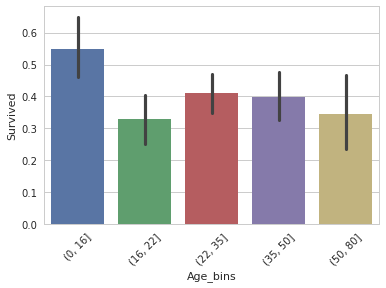

In [569]:
bins = [0, 16, 22, 35, 50, 80]
train_df['Age_bins'] = pd.cut(train_df['Age'], bins)

sns.barplot(x='Age_bins', y='Survived', data=train_df)
plt.xticks(rotation=45)
plt.show()

train_df = train_df.drop(['Age_bins'], axis=1)

## 3.11. Fare Analysis

In [570]:
train_df['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

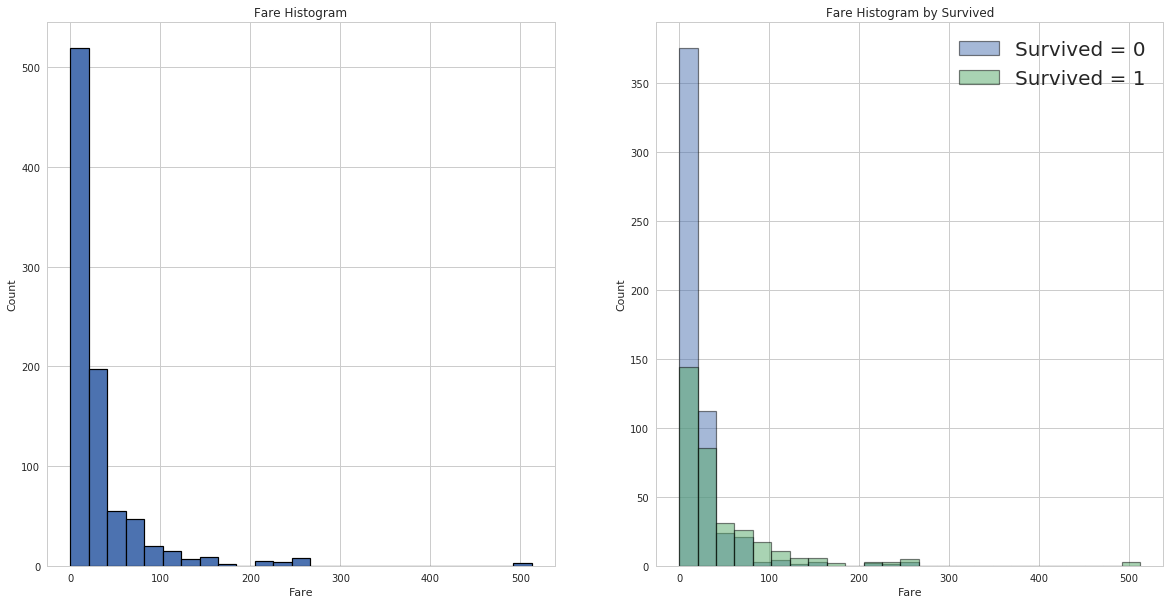

In [571]:
_, (ax1, ax2) = plt.subplots(1, 2,figsize=(20, 10))
_, bins = np.histogram(train_df['Fare'], bins=25)
ax1.hist(train_df['Fare'].dropna(), bins=bins, edgecolor='black', linewidth=1.2)
ax1.set_xlabel('Fare')
ax1.set_ylabel('Count')
ax1.set_title('Fare Histogram')
ax2.hist(train_df.loc[train_df.Survived == 0, 'Fare'].dropna(), bins=bins, edgecolor='black', linewidth=1.2, alpha=0.5, label='Survived = 0')
ax2.hist(train_df.loc[train_df.Survived == 1, 'Fare'].dropna(), bins=bins, edgecolor='black', linewidth=1.2, alpha=0.5, label='Survived = 1')
ax2.set_xlabel('Fare')
ax2.set_ylabel('Count')
ax2.set_title('Fare Histogram by Survived')
plt.legend(loc='best', prop={'size': 20})
plt.show()

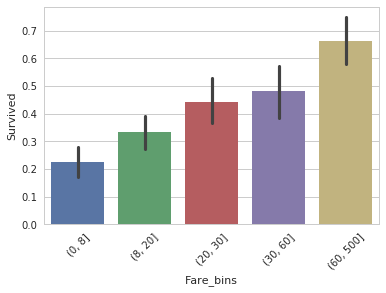

In [572]:
bins = [0, 8, 20, 30, 60, 500]
train_df['Fare_bins'] = pd.cut(train_df['Fare'], bins)

sns.barplot(x='Fare_bins', y='Survived', data=train_df)
plt.xticks(rotation=45)
plt.show()

train_df = train_df.drop(['Fare_bins'], axis=1)

# 4. Feature Engineering

In [573]:
# Concatenate training and test data

full_data = pd.concat([train_df.drop('Survived', axis=1), test_df], axis=0)
labels = train_df['Survived']


# Extract Title

full_data['Title'] = full_data['Name'].apply(lambda x: re.sub('(.*, )|(\\..*)', '', x))
full_data['Title'].replace('Mlle', 'Miss', inplace=True)
full_data['Title'].replace('Ms', 'Miss', inplace=True)
full_data['Title'].replace('Mme', 'Mrs', inplace=True)
full_data['Title'] = full_data['Title'].apply(lambda x: 'Rare' if x not in ['Mr', 'Miss', 'Mrs', 'Master'] else x)


# Extract hasCabin

full_data['hasCabin'] = 0
full_data.loc[~ full_data.Cabin.isnull(), 'hasCabin'] = 1


# Extract Ticketcounts

full_data['CountTickets'] = full_data['Ticket'].map(full_data['Ticket'].value_counts())


# Extract FamilySize

full_data['FamilySize'] = full_data['SibSp'] + full_data['Parch']


# EXtract isAlone

full_data['isAlone'] = 1
full_data.loc[full_data.FamilySize > 0, 'isAlone'] = 0


# Drop variables and generate dummies
       
full_data = full_data.drop(['Name', 'Ticket', 'Cabin'], axis=1)
full_data['Pclass'] = full_data['Pclass'].astype('str')
full_data = pd.get_dummies(full_data)


# Reconstruct train and test data

features_train = full_data[:train_df.shape[0]]
features_test = full_data[train_df.shape[0]:]

print('FEATURES TRAIN:\n')
print(features_train.info())

print()

print('FEATURES TEST:\n')
print(features_test.info())

FEATURES TRAIN:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 17 columns):
Age             714 non-null float64
SibSp           891 non-null int64
Parch           891 non-null int64
Fare            891 non-null float64
Pclass_1        891 non-null uint8
Pclass_2        891 non-null uint8
Pclass_3        891 non-null uint8
Sex_female      891 non-null uint8
Sex_male        891 non-null uint8
Embarked_C      891 non-null uint8
Embarked_Q      891 non-null uint8
Embarked_S      891 non-null uint8
Title_Master    891 non-null uint8
Title_Miss      891 non-null uint8
Title_Mr        891 non-null uint8
Title_Mrs       891 non-null uint8
Title_Rare      891 non-null uint8
dtypes: float64(2), int64(2), uint8(13)
memory usage: 46.1 KB
None

FEATURES TEST:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 17 columns):
Age             332 non-null float64
SibSp           418 non-null int64
Parch          

In [574]:
features_train.head()

,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
PassengerId,,,,,,,,,,,,,,,,,
1,22.0,1,0,7.2500,0,0,1,0,1,0,0,1,0,0,1,0,0
2,38.0,1,0,71.2833,1,0,0,1,0,1,0,0,0,0,0,1,0
3,26.0,0,0,7.9250,0,0,1,1,0,0,0,1,0,1,0,0,0
4,35.0,1,0,53.1000,1,0,0,1,0,0,0,1,0,0,0,1,0
5,35.0,0,0,8.0500,0,0,1,0,1,0,0,1,0,0,1,0,0


In [575]:
features_test.head()

,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
PassengerId,,,,,,,,,,,,,,,,,
892,34.5,0,0,7.8292,0,0,1,0,1,0,1,0,0,0,1,0,0
893,47.0,1,0,7.0000,0,0,1,1,0,0,0,1,0,0,0,1,0
894,62.0,0,0,9.6875,0,1,0,0,1,0,1,0,0,0,1,0,0
895,27.0,0,0,8.6625,0,0,1,0,1,0,0,1,0,0,1,0,0
896,22.0,1,1,12.2875,0,0,1,1,0,0,0,1,0,0,0,1,0


# 5. Supervised Machine Learning

## 5.1. Set up

In [576]:
# Extract features and labels

X_train = features_train.values
y_train = labels.values
X_test = features_test.values

imputer = Imputer();
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create aux functions

    
class HelperClass:
    
    def __init__(self, X, y):
        self.X, self.y = X, y
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y,
                                                                               test_size=.2,
                                                                               random_state=42, stratify=self.y)
        return self
    
    def score(est, params, cv):
        return  GridSearchCV(est, param_grid=params, cv=cv, n_jobs=-1).fit(X_train, y_train).score(X_test, y_test)
    
    def train_model(est, params, cv):
        return GridSearchCV(est, param_grid=params, cv=cv, n_jobs=-1).fit(X, y).best_estimator_



def print_results(scores):
    for item in scores:
        print("Accuracy: %0.2f [%s]" % (item[1], item[0]))
    return None


def create_submissions(trained_pipes, X_test):
    for name, pipe in trained_pipes:
        y_pred = pipe.predict(X_test)
        pd.DataFrame(y_pred, columns=['Survived'], index=features_test.index).reset_index().to_csv('{}.csv'.format(name), index=False)

        
# Logistic Regression set up

log = LogisticRegression(penalty='l2')


# Kernelized SVC set up

kernel_svc = SVC(kernel='rbf')


# Random Forest set up

forest = RandomForestClassifier(n_estimators=100, random_state=0)


# KNN set up

knn = KNeighborsClassifier()


# Stacking classifier

sclf = StackingCVClassifier(classifiers=[log, forest, knn], meta_classifier=kernel_svc, use_probas=True)

# Params

params_sclf = {'logisticregression__C' : [.1, 1, 10],
               'kneighborsclassifier__n_neighbors' : np.arange(5, 15 + 1),
               'meta-svc__C' : [.1, 1, 10],
               'meta-svc__gamma' : [.001, .01, .1]}

params_log = {'logisticregression__C' : [.1, 1, 10]}

params_kernel_svc = {'svc__C' : [.1, 1, 10],
                     'svc__gamma' : [.001, .01, .1]}

params_knn = {'kneighborsclassifier__n_neighbors' : np.arange(5, 15 + 1)}


#





In [577]:
grid.best_estimator_.clfs_

[LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False),
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_jobs=1, oob_score=False, random_state=0,
             verbose=0, warm_start=False),
 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=None, n_jobs=1, n_neighbors=6, p=2,
            weights='uniform'),
 GaussianNB(priors=None)]

In [578]:
grid.best_estimator_.meta_clf_

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)